## Vertical profiles of shortwave, longwave and net cloud radiative heating rates as area mean and time mean over NAWDEX ocean region using:

## ICON simulations

## ERA5 reanalysis datasets & CloudSat/Calipso

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from dask.distributed import Client, progress, wait
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45072 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 268.44 GB


In [2]:
# importing utility dictionaries
import sys
sys.path.append('/pf/b/b381185/behrooz/Hackathon_b/nawdex-hackathon/shared')

# simulations dictionary
import dict_nawdexsims
simdict = dict_nawdexsims.simdictionary()

# dictionary for the days to be analyzed
anadaysdict = dict_nawdexsims.anadaysdictionary()

# dictionary for colors
colordict = dict_nawdexsims.colordictionary()

## Deriving height at full levels

In [3]:
def get_fulllevel_height():
    # define simulation
    resolution = '80km'
    sim = '0001'
    expid = 'nawdexnwp-' + resolution + '-mis-' + sim
    # read ocean mask
    ipath_oceanmask = '/work/bb1018/nawdex-hackathon_pp/'
    da_ocean = xr.open_dataset(ipath_oceanmask + '/openoceanmask/' + expid + \
                               '_openoceanmask.nc')['mask_openocean']
    index = np.where(da_ocean == 1)[0]
    del da_ocean, ipath_oceanmask
    # read z_ifc data
    ipath = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/' + \
            'nawdexnwp-' + resolution + '-mis-' + sim + '/'
    ds = xr.open_dataset(ipath + 'nawdexnwp-' + resolution + '-mis-' + \
                         sim + '_2016092200_fg_DOM01_ML_0036.nc')
    del ipath
    # apply ocean mask on z_ifc to make sure to look at ocean grid point
    ds = ds.isel(ncells=index)
    # calculate full levels based on z_ifc
    z_full = (ds.z_ifc[:,0] - (ds.z_ifc[:,0].diff('height_3')/2)).values
    #print(z_full)
    del resolution, sim, expid, index, ds
    return z_full

zfull = get_fulllevel_height()

## Load domain mean_open ocean radiative heating rates / ICON Simulations

In [4]:
sim_set_1 = []

for sim in list(simdict.keys()):
    
    path = '/work/bb1018/nawdex-hackathon_pp/radiative_heating_domain_mean/'
        
    ds = xr.open_dataset(path+'atmradheating_fldmean_openocean_'+sim+'.nc')
    
    # deriving cloud sw, lw and net radiative heating rates
    
    ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
    ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
    ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
    ds.attrs['simulation'] = sim    
     
    # Only the selected days 
    
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
        
    sim_set_1.append(ds)
    
    del sim

## Merge datasets for climatology average with regard to their resolution, convection and microphysics shcemes

In [5]:
def time_merge_list(sim_set,resolution):
    
    # empty list for diffrent setups
    ds_merge1 = []
    ds_merge2 = []
    ds_merge3 = []
    ds_merge4 = []
    ds_merge5 = []
    ds_merge6 = []
       
    for i in range(len(sim_set)):
        
        conv = simdict[sim_set[i].attrs['simulation']]['conv']
        mphys = simdict[sim_set[i].attrs['simulation']]['mphys']
        res = simdict[sim_set[i].attrs['simulation']]['res']
        
        if conv == 1 and mphys ==1 and res==resolution:
            
            ds_merge1.append(sim_set[i])
            ds1 = xr.concat(ds_merge1,dim='time')
            
        elif conv == 1 and mphys ==2 and res==resolution:
            
            ds_merge2.append(sim_set[i])
            ds2 = xr.concat(ds_merge2,dim='time')
            
        elif conv == 0 and mphys ==1 and res==resolution:
            
            ds_merge3.append(sim_set[i])
            ds3 = xr.concat(ds_merge3,dim='time')
         
        elif conv == 0 and mphys ==2 and res==resolution:
            
            ds_merge4.append(sim_set[i])
            ds4 = xr.concat(ds_merge4,dim='time')
            
        elif conv == 2 and mphys ==1 and res==resolution:
            
            ds_merge5.append(sim_set[i])
            ds5 = xr.concat(ds_merge5,dim='time')
            
        elif conv == 2 and mphys ==2 and res==resolution:
            
            ds_merge6.append(sim_set[i])
            ds6 = xr.concat(ds_merge6,dim='time')
            
    if resolution=='80km' or resolution=='40km' or resolution=='20km' or resolution=='10km' or resolution=='5km':
        
        return (ds1,ds2) # Only with convection on / 1 and 2 moment mphy
    
    else:
        
        return (ds3,ds4,ds5,ds6) #( for 2km resolution with conv:off/only shallow convection, 1 and 2 moment mphy)

In [6]:
# executing upper fuction and putting all simulations into a list 

list_climatology = []

for res in ['80km','40km','20km','10km','5km','2km']:
    
    list_climatology.append(time_merge_list(sim_set_1,res))
    
# change from tuple to list

c_list = list_climatology[0]+list_climatology[1]+list_climatology[2]+list_climatology[3]+list_climatology[4]+list_climatology[5]   

icon_list = list(c_list)   

## Plot vertical profiles of cloud radiative heating rates

In [7]:
# function for plotting vertical profiles

# ** for ERA5
# choise of height or level selection is based on 
# https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels:
# where index 64 is appro. 15 Km and index 98 is approximaetly 5 Km

def plot_thmean(_ds_icon_list, _var,num):
    
    ax = fig.add_subplot(2,3,num)
    fig.tight_layout(pad=2.5)
    
    for ds in _ds_icon_list:
        # make sure that _var is part of dataset
        if _var not in ds.keys():
            continue
        
        # Options for ERA5 CRH 
        if ds.attrs['simulation'] == 'ERA5_sep_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1 
        
        elif ds.attrs['simulation'] == 'ERA5_oct_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1
         
        elif ds.attrs['simulation'] == 'ERA5_sep_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2 
        
        elif ds.attrs['simulation'] == 'ERA5_oct_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2
        
        # options for CloudSat data
        elif ds.attrs['simulation'] == 'CC_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1
            
        elif ds.attrs['simulation'] == 'CC_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2    
            
        # ICON_simulations
        else:
            
            # get plotting color according to ICON resolution

            pcolor=colordict[simdict[ds.attrs['simulation']]['res']]
            # get linestyle according to convection scheme
            conv = simdict[ds.attrs['simulation']]['conv']
            if conv==0:
                lstyle='--'
            elif conv==1:
                lstyle='-'
            elif conv==2:
                lstyle=':'

            mphys = simdict[ds.attrs['simulation']]['mphys']
            
            
        if mphys==1:
            
            ax = fig.add_subplot(2,3,num)
            
            # ERA5 plot
            if ds.attrs['simulation'] == 'ERA5_sep_1':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')
            
            elif ds.attrs['simulation'] == 'ERA5_oct_1':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')
                
            # CloudSat/Calipso
            elif ds.attrs['simulation'] == 'CC_1':
                
                plt.plot(ds[_var].isel(lev=slice(41,83)).values,height_cc,
                     color='k',linewidth=2,linestyle='solid',label='CloudSat/Calipso')
            
            # ICON_sims plots
            else:
                
            # average over 14 days_Climatology
                
                line = ds[_var].sel(height=slice(16,50)).mean('time')
                dailymean = ds[_var].sel(height=slice(16,50)).groupby('time.day').mean('time')
                std_height = np.std(dailymean,axis=0)
                ste_height = std_height/np.sqrt(np.size(dailymean['day']))

                plt.plot(line.values*86400,zfull[15:50]/1e3,color=pcolor,linestyle=lstyle,
                         linewidth=2,label=simdict[ds.attrs['simulation']]['res'])
                
                if simdict[ds.attrs["simulation"]]["res"]=="80km":
                    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-std_height)*86400,
                                      x2=(line+std_height)*86400, color = pcolor, alpha=0.2) 
                    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-ste_height)*86400,
                                      x2=(line+ste_height)*86400, color = pcolor, alpha=0.3)
                
            
            plt.tick_params(labelsize=13)
            #plt.ylabel("Height (km)",fontsize=12)
            
            if num == 1:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.3,0.3)#(-0.25,0.25)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                plt.xlim(-0.3,0.3)#(-0.25,0.25)
                plt.ylim(5,15)
                
                plt.title('Microphysics: One-moment scheme',fontsize=15, pad=20)
                plt.xlabel('SW_cloud_r heating rate (K/day)',fontsize=14)
                plt.legend(fontsize=12)
                plt.ylabel("Height (km)",fontsize=14)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3])
                ax.xaxis.set_ticklabels([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], fontsize=13)#,fontweight='bold')
                
            if num == 2:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('LW_cloud_r heating rate (K/day)',fontsize=14)
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
            if num == 3:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('Net_cloud_r heating rate (K/day)',fontsize=14)
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=14)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
        
            
        elif mphys==2:
            
            ax = fig.add_subplot(2,3,num+3)
            
            # ERA5 plot
            if ds.attrs['simulation'] == 'ERA5_sep_2':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')
            
            elif ds.attrs['simulation'] == 'ERA5_oct_2':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')
                
            # CloudSat/Calipso
            elif ds.attrs['simulation'] == 'CC_2':
                
                plt.plot(ds[_var].isel(lev=slice(41,83)).values,height_cc,
                     color='k',linewidth=2,linestyle='solid',label='CloudSat/Calipso')    
            
            # ICON_sims plots
            else:
                
            # average over 14 days_Climatology
                
                line = ds[_var].sel(height=slice(16,50)).mean('time')
                dailymean = ds[_var].sel(height=slice(16,50)).groupby('time.day').mean('time')
                std_height = np.std(dailymean,axis=0)
                ste_height = std_height/np.sqrt(np.size(dailymean['day']))

                plt.plot(line.values*86400,zfull[15:50]/1e3,color=pcolor,linestyle=lstyle,
                         linewidth=2,label=simdict[ds.attrs['simulation']]['res'])
                
                if simdict[ds.attrs["simulation"]]["res"]=="80km":
                    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-std_height)*86400,
                                      x2=(line+std_height)*86400, color = pcolor, alpha=0.2) 
                    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-ste_height)*86400,
                                      x2=(line+ste_height)*86400, color = pcolor, alpha=0.3)
            
            if num+3 == 4:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.3,0.3)#(-0.25,0.25)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlim(-0.3,0.3)#(-0.25,0.25)
                
                plt.title('Microphysics: Two-moment scheme',fontsize=15, pad=20)
                plt.xlabel('SW_cloud_r heating rate (K/day)',fontsize=14)
                plt.ylabel("Height (km)",fontsize=14)
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.legend(fontsize=12)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3])
                ax.xaxis.set_ticklabels([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], fontsize=13)#,fontweight='bold')
                
            if num+3 == 5:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('LW_cloud_r heating rate (K/day)',fontsize=14)
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
            if num+3 == 6:
                
                ax.spines['left'].set_bounds(5,15)
                ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('Net_cloud_r heating rate (K/day)',fontsize=14)#,fontweight='bold')
                ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
            

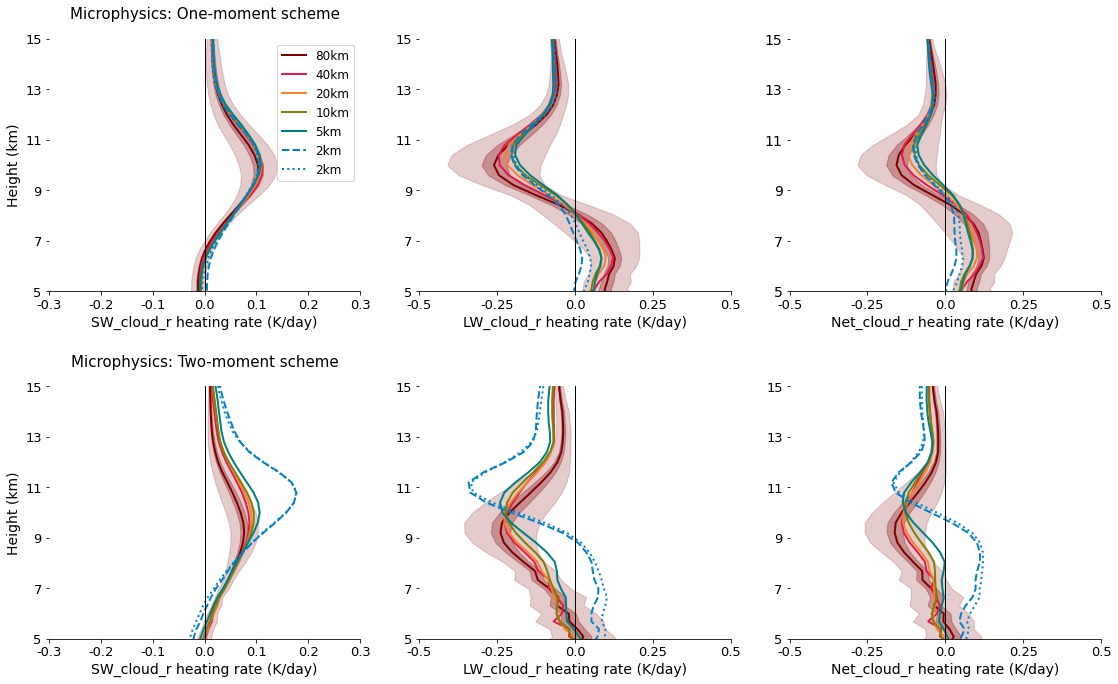

In [8]:
# vertical profiles of ICON cloud-rad heating rates: all resolution and different microphysics

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['sw_crh','lw_crh','nt_crh']:
    
    i = i + 1
    
    plot_thmean(icon_list, var,i)
    
    #plt.savefig('clim_crh', bbox_inches = 'tight', dpi=600)

## Vertical profiles for 1 period of simulations (22092016)

Simulations added :

10, 5 km convection off

2.5 Km convection on

In [12]:
sim_set_2 = []

for sim in list(simdict.keys()):
    
    path = '/work/bb1018/nawdex-hackathon_pp/radiative_heating_domain_mean/'
    
    # only the simulations start at 22092016
    
    if simdict[sim]['start'] == '20160922':
        
        ds = xr.open_dataset(path+'atmradheating_fldmean_openocean_'+sim+'.nc')
        
        # deriving the lw, sw and net cloud radiative heating rates
        
        ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
        ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
        ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
        ds.attrs['simulation'] = sim
    
        # Only the selected days
        startday  = simdict[sim]['start']
        anadays = anadaysdict[startday]

        ds = ds.sel(time=slice(anadays[0], anadays[-1]))
     
        sim_set_2.append(ds)
    
        del sim

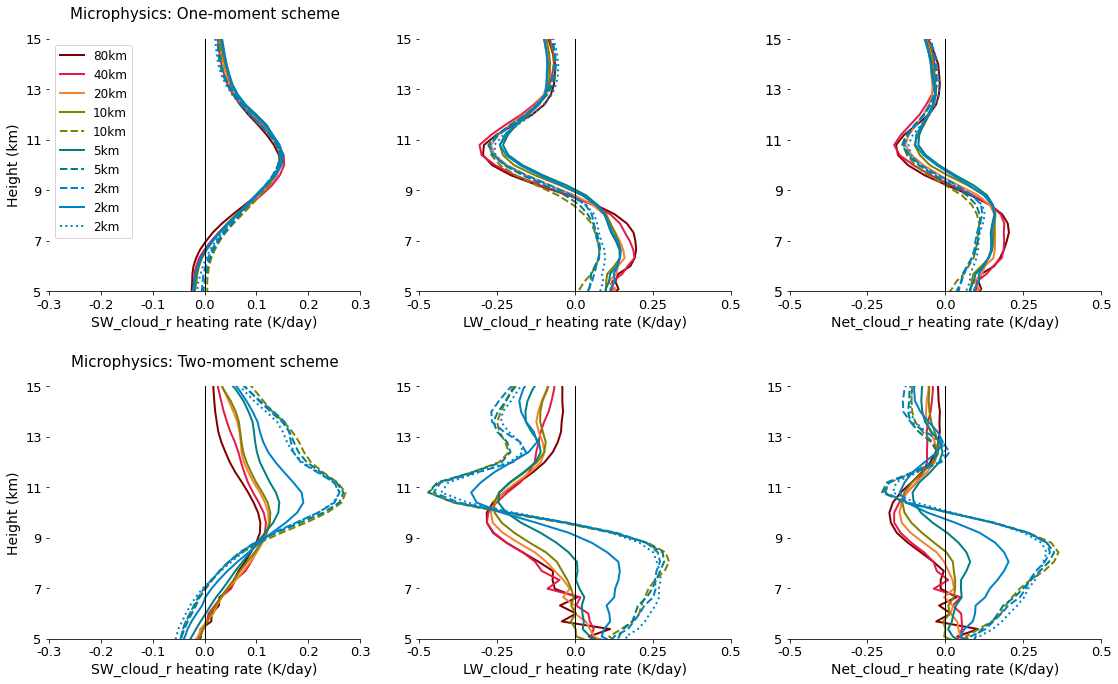

In [13]:
# vertical profiles of cloud-rad heating rates: all resolution and different microphysics for 1 period

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['sw_crh','lw_crh','nt_crh']:
    
    i = i + 1
    
    plot_thmean(sim_set_2, var,i)
    
    #plt.savefig('22_crh', bbox_inches = 'tight', dpi=600)

## ERA5 cloud-radiative heating averaged over the NAWDEX ocean domain region

Data retrieved using cds_api for the same simulated days with ICON for NAWDEX. 

Hourly datasets initialized at 06:00 and 18:00 with 0.25*0.25 resolution  
Area: over 23_80N 78W40E

## Load cloud radiative fluxes / excluding boundaries / time average over the 14 days or 5 year climatology

In [193]:
# Selecting days same as ICON nawdex simulations

seldays = ['2016-09-21', '2016-09-22',
               '2016-09-23', '2016-09-24', '2016-09-25',
               '2016-09-30', '2016-10-01', '2016-10-02',
               '2016-10-03', '2016-10-04', '2016-10-05',
               '2016-10-14', '2016-10-15', '2016-10-16']

# the period of simulations where all ICON_model setups at different resolution exist

seldays_2 = ['2016-09-23', '2016-09-24', '2016-09-25']

#--------------------------------------------------------------------------------------

# 5 year climatology for september and october

seldays_sep = []

for year in ['2012','2013','2014','2015','2016']:
    for i in range(1,31,1): 
        for day in [str(i)]:
            if i in np.arange(1,10,1):
                seldays_sep.append(year+'-09-0'+day)   
            else:
                seldays_sep.append(year+'-09-'+day)
                
seldays_oct = []

for year in ['2012','2013','2014','2015','2016']:
    for i in range(1,32,1): 
        for day in [str(i)]:
            if i in np.arange(1,10,1):
                seldays_oct.append(year+'-10-0'+day)   
            else:
                seldays_oct.append(year+'-10-'+day)
                
                
seldays_all = seldays_sep + seldays_oct
#----------------------------------------------------------------------------------------

path = '/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/netcdf/'

ds = xr.open_mfdataset(path+'ERA5_ddt_mean*')

# deriving lw, sw and net cloud radiative heating rates

ds['lw_crh'] = ds['mttlwr'] - ds['mttlwrcs'] 
ds['sw_crh'] = ds['mttswr'] - ds['mttswrcs']
ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']

# Choosing desired days

ds_merge = []

for i in range(len(seldays_all)):
    
    ds_merge.append(ds.sel(time=seldays_all[i]))
    
    ds_t = xr.concat(ds_merge,dim='time')

# select lon-lat box the same as ICON simulations used for the analysis
# 32N and 71N, and 63W and 24E

ds_rh = (ds_t.sel(lat=slice(71,32),lon=slice(-63,24)))

# Time mean over 14 selected days

ds_rh_tmean = ds_rh.mean('time')

## Load sea-land mask and sea-ice fraction to only work with open ocean data

In [194]:
# loading sea_ice_fraction and land_sea mask 

path_lsm = '/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/'

ds_lsm = xr.open_dataset(path_lsm+'201609-land-sea-mask.nc').mean('time')

# sea_ice 

path_ci = '/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/sea_ice_cover/netcdf/'

ds_ci = xr.open_mfdataset(path_ci+'ERA5_sea_ice*.nc')

# for just 1 period of simulations---------------------

ds_merge_ci = []

for i in range(len(seldays_all)):
    
    ds_merge_ci.append(ds_ci.sel(time=seldays_all[i]))
    
    ds_ci_t = xr.concat(ds_merge_ci,dim='time')
    
#------------------------------------------------------    

# merge

ds_ci_lsm = xr.merge([ds_lsm, ds_ci_t]).rename({'latitude': 'lat','longitude': 'lon'})

# select lon-lat box the same as ICON simulations used for the analysis
# 32N and 71N, and 63W and 24E

ds_ci_lsm = (ds_ci_lsm.sel(lat=slice(71,32),lon=slice(-63,24)))

## Masking radiative datasets and take area mean

In [6]:
# merge radiative dataset with openocean mask dataset

ds_out  = xr.merge([ds_rh_tmean, ds_ci_lsm])

# average spatially over the ocean

weights = np.cos(np.deg2rad(ds_out.lat))
weights.name = "weights"

#set weights to zero over land and areas with ice fraction

weights = weights * xr.where(ds_out['lsm']+ds_out['siconc'].max('time')<0.1, 1, 0) 

ERA5_mean = ds_out.weighted(weights).mean(dim=['lat','lon'])

In [7]:
# for 5 year climatology save the final dataset due to time consuming computation

#ERA5_mean.to_netcdf('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_sep.nc')
#ERA5_mean.to_netcdf('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_oct.nc')
ERA5_mean.to_netcdf('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_all.nc')

In [65]:
# loading prevoius datasets

ERA5_mean_sep_1 = xr.open_dataset('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_sep.nc')
ERA5_mean_oct_1 = xr.open_dataset('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_oct.nc')
ERA5_mean_all_1 = xr.open_dataset('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/ERA5_mean_all.nc')

ERA5_mean_sep_2 = ERA5_mean_sep_1.copy()
ERA5_mean_oct_2 = ERA5_mean_oct_1.copy()
ERA5_mean_all_2 = ERA5_mean_all_1.copy()


ERA5_mean_all_1.attrs['simulation'] = 'ERA5_all_1'
ERA5_mean_sep_1.attrs['simulation'] = 'ERA5_sep_1'
ERA5_mean_oct_1.attrs['simulation'] = 'ERA5_oct_1'

ERA5_mean_all_2.attrs['simulation'] = 'ERA5_all_2'
ERA5_mean_sep_2.attrs['simulation'] = 'ERA5_sep_2'
ERA5_mean_oct_2.attrs['simulation'] = 'ERA5_oct_2'

## Plot cloud radiative heating rates

[Text(-0.5, 0, '-0.5'),
 Text(-0.25, 0, '-0.25'),
 Text(0.0, 0, '0.0'),
 Text(0.25, 0, '0.25'),
 Text(0.5, 0, '0.5')]

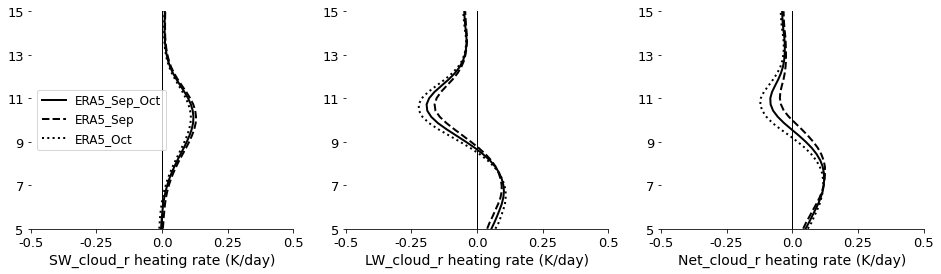

In [19]:
# plot between 5 and 15 Km

# choise of height or level selection is based on 
# https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels:
# where index 64 is appro. 15 Km and index 98 is approximaetly 5 Km

height = np.linspace(5, 15, 36)
height.shape

fig=plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)

plt.plot(ERA5_mean_all.sw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='solid',label='ERA5_Sep_Oct')

plt.plot(ERA5_mean_sep.sw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')

plt.plot(ERA5_mean_oct.sw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')

ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)

ax.spines['left'].set_bounds(5,15)
ax.spines['bottom'].set_bounds(-0.5,0.5)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
plt.xlabel('SW_cloud_r heating rate (K/day)',fontsize=14)#,fontweight='bold')
plt.legend(fontsize=12)

plt.xlim(-0.5,0.5)
plt.ylim(5,15)
ax.yaxis.set_ticks([5,7,9,11,13,15])
ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')

# lw
ax = fig.add_subplot(1,3,2)

plt.plot(ERA5_mean_all.lw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='solid',label='ERA5_Sep_Oct')

plt.plot(ERA5_mean_sep.lw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')

plt.plot(ERA5_mean_oct.lw_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')

plt.xlabel('LW_cloud_r heating rate (K/day)',fontsize=14)#,fontweight='bold')
ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)

ax.spines['left'].set_bounds(5,15)
ax.spines['bottom'].set_bounds(-0.5,0.5)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

plt.xlim(-0.5,0.5)
plt.ylim(5,15)
ax.yaxis.set_ticks([5,7,9,11,13,15])
ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')

# net
ax = fig.add_subplot(1,3,3)

plt.plot(ERA5_mean_all.nt_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='solid',label='ERA5_Sep_Oct')

plt.plot(ERA5_mean_sep.nt_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')

plt.plot(ERA5_mean_oct.nt_crh.sel(lev=slice(64,99)).values[::-1]*86400,height,
         color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')

plt.xlabel('Net_cloud_r heating rate (K/day)',fontsize=14)#,fontweight='bold')
ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)

ax.spines['left'].set_bounds(5,15)
ax.spines['bottom'].set_bounds(-0.5,0.5)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

plt.xlim(-0.5,0.5)
plt.ylim(5,15)
ax.yaxis.set_ticks([5,7,9,11,13,15])
ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')

## Combine ERA5 with ICON dataset

In [66]:
# adding 'ERA5_mean' to ICON simulations 'icon_list' 

ds_all = icon_list.copy()

ds_all.append(ERA5_mean_sep_1)
ds_all.append(ERA5_mean_oct_1)
ds_all.append(ERA5_mean_sep_2)
ds_all.append(ERA5_mean_oct_2)

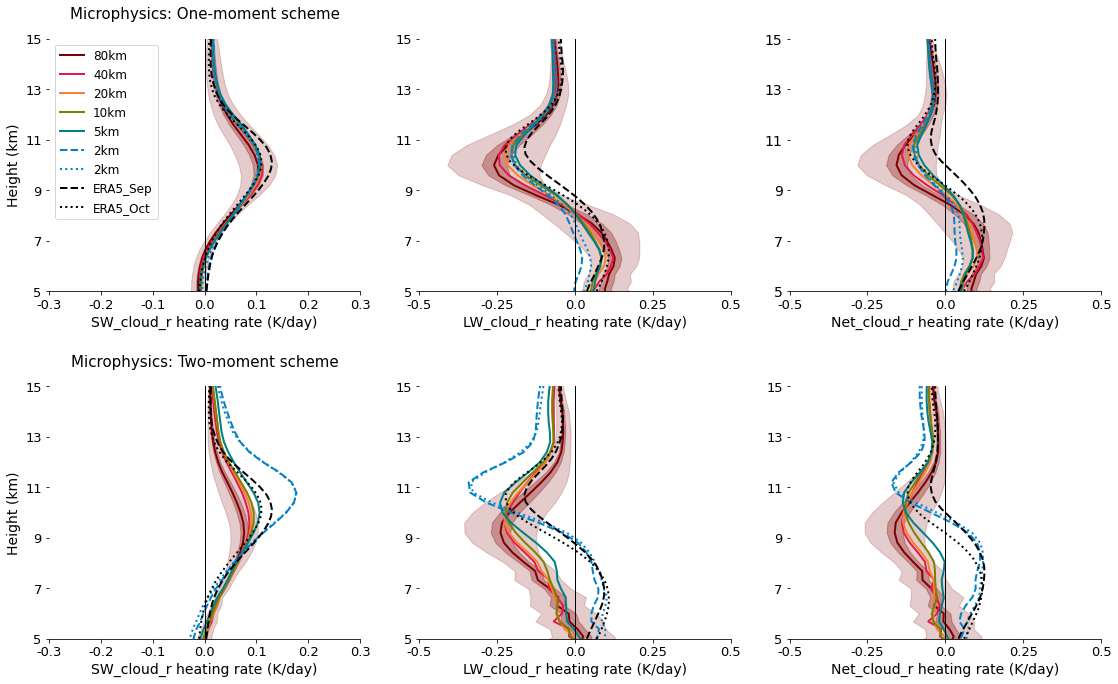

In [74]:
# vertical profiles of cloud-rad heating rates: ICON simulations and ERA5

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['sw_crh','lw_crh','nt_crh']:
    
    i = i + 1
    
    plot_thmean(ds_all, var,i)
    
    #plt.savefig('clim_crh', bbox_inches = 'tight', dpi=600)

## for just 1 period of simulation

In [214]:
# adding 'ERA5_mean' to ICON simulations for the period 22092016 'sim_set_2' 

ds_all_2 = sim_set_2.copy()

ds_all_2.append(ERA5_mean_1)
ds_all_2.append(ERA5_mean_2)

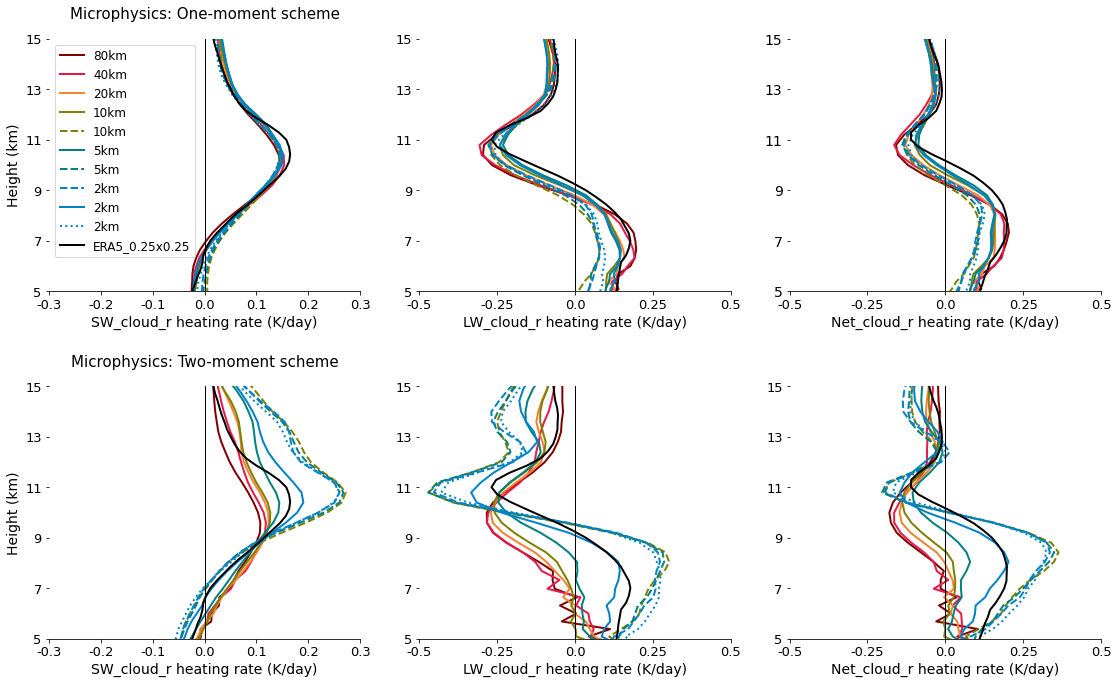

In [215]:
# vertical profiles of cloud-rad heating rates: ICON simulations and ERA5 for the period 22092016

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['sw_crh','lw_crh','nt_crh']:
    
    i = i + 1
    
    plot_thmean(ds_all_2, var,i)
    
    #plt.savefig('clim_crh', bbox_inches = 'tight', dpi=600)

## CloudSat/Calipso

In [158]:
# loading dataset

ds_cc2 = xr.open_dataset('/work/bb1018/nawdex-hackathon_pp/ERA5_0.25x0.25_nawdex/cloudsat_calipso/cloudsat_calipso_global_3d_acre_multiyear_clim_0.25x0.25.nc')

# selection of the domain of interest 

ds_dcc2 = ds_cc2.sel(lat=slice(32,71),lon=slice(-63,24)).mean('time')

# merge it with ERA5 land sea and ice fraction for filtering

ds_out_cc  = xr.merge([ds_dcc2, ds_ci_lsm])

# creating weigths for domain-mean calculation

weights_cc = np.cos(np.deg2rad(ds_dcc.lat))
weights_cc.name = "weights"

#set weights to zero over land and areas with ice fraction

weights_cc = weights_cc * xr.where(ds_out_cc['lsm']+ds_out_cc['siconc'].max('time')<0.1, 1, 0) 

CC_mean = ds_dcc.weighted(weights_cc).mean(dim=['lat','lon'])

# change the variable names consistant with the other dataset

CC_mean['sw_crh'] = CC_mean['sw_acre_clim']
CC_mean['lw_crh'] = CC_mean['lw_acre_clim']
CC_mean['nt_crh'] = CC_mean['acre_clim']

# adding attribute

CC_mean.attrs['simulation'] = 'CC_1'

# make a copy as for the plot
CC_mean_2 = CC_mean.copy()
CC_mean_2.attrs['simulation'] = 'CC_2'

In [161]:
# adding these two dataset to the ICON+ERA5 datasets

ds_all.append(CC_mean)
ds_all.append(CC_mean_2)

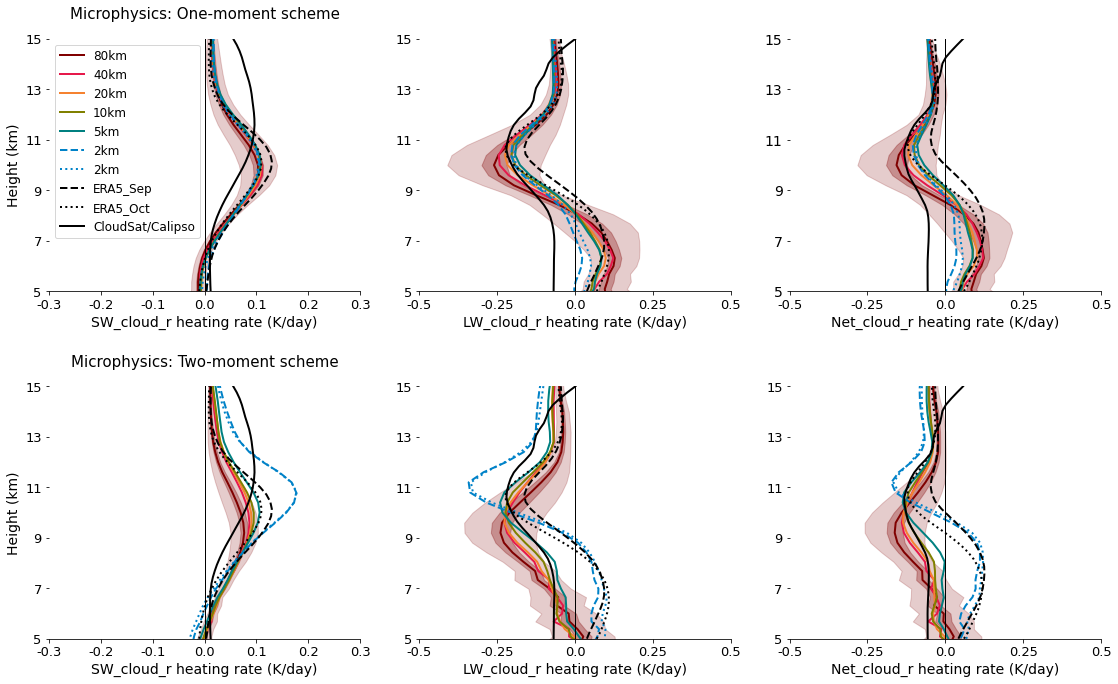

In [201]:
# vertical profiles of cloud-rad heating rates: ICON simulations and ERA5

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['sw_crh','lw_crh','nt_crh']:
    
    i = i + 1
    
    plot_thmean(ds_all, var,i)
    
    plt.savefig('clim_crh', bbox_inches = 'tight', dpi=300)